In [6]:
import geopandas as gpd
import pandas as pd

import networkx as nx
import osmnx as ox

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiLineString
from descartes import PolygonPatch

<h2>Adding Datasets</h2>

In [2]:
#Seattle City Boundary Polygon
seaCity = gpd.read_file("./data/Seattle_Area_Polygon_-142470933516081067.geojson")
seaCity = seaCity.to_crs('EPSG:32610')

In [3]:
#Seattle Bike Facilities
sGraph = ox.load_graphml('./data/Sgraph_planned.graphml')

<h3>Plots</h3>

<Axes: >

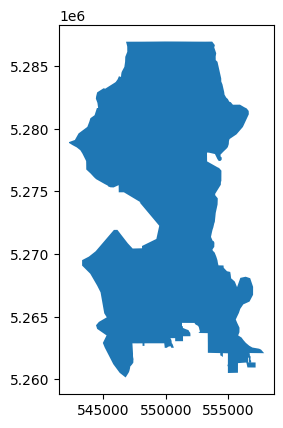

In [4]:
seaCity.plot()

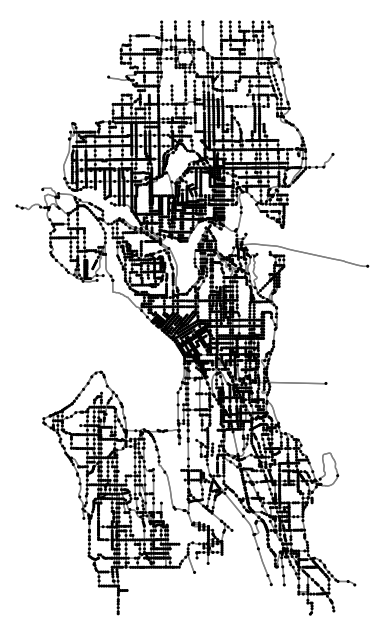

In [5]:
fig, ax = ox.plot_graph(sGraph, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

<h2>Isochrone Polygons</h2>

In [7]:
graph_proj = ox.project_graph(sGraph, to_crs='EPSG:4326')
nodes = ox.graph_to_gdfs(graph_proj, nodes=True, edges=False)

In [8]:
#seattle coordinates are [47.605465173774206, -122.3192423656039]
test = nodes[nodes['y']>47.605]
test = test[test['y']<47.606]
test = test[test['x']> -122.319]
test

,nodeID,x,y,lon,lat,geometry
osmid,,,,,,
53,53,-122.305052,47.605169,552234.177163,5.272652e+06,POINT (-122.30505 47.60517)
2185,2185,-122.316796,47.605202,551351.474297,5.272648e+06,POINT (-122.31680 47.60520)
1352,1352,-122.316796,47.605573,551351.126830,5.272689e+06,POINT (-122.31680 47.60557)
3352,3352,-122.305055,47.605172,552233.969085,5.272652e+06,POINT (-122.30505 47.60517)
5257,5257,-122.283621,47.605921,553844.198616,5.272750e+06,POINT (-122.28362 47.60592)
5425,5425,-122.292648,47.605179,553166.474079,5.272661e+06,POINT (-122.29265 47.60518)


In [9]:
node_manual = 1352
sGraph = ox.project_graph(graph_proj, to_crs='EPSG:32610')

In [10]:
travel_speed = 16
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in sGraph.edges.data():
    data['time'] = data['length'] / meters_per_minute

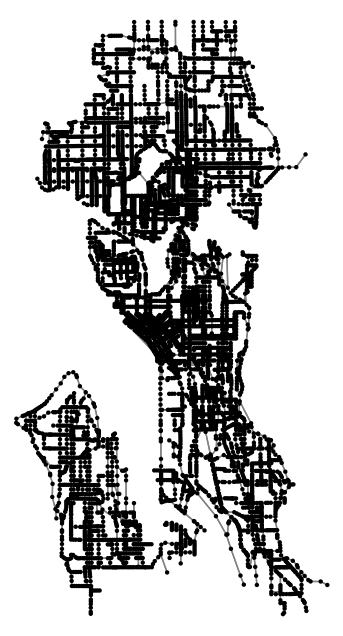

In [11]:
subgraph = nx.ego_graph(sGraph, node_manual, radius=360, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

In [12]:
trip_times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # in minutes
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10127/2306092675.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)


In [13]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph1 = nx.ego_graph(sGraph, node_manual, radius=trip_time, distance="time")
    for node in subgraph1.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in sGraph.nodes()]
ns = [10 if node in node_colors else 0 for node in sGraph.nodes()]

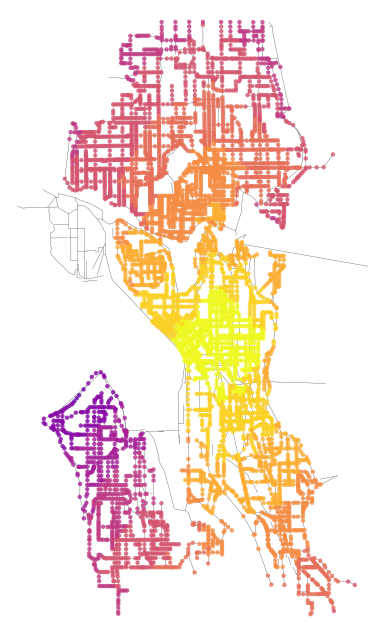

In [14]:
fig, ax = ox.plot_graph(sGraph, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

In [15]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, node_manual, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [16]:
isochrone_polys = make_iso_polys(sGraph, edge_buff=25, node_buff=0, infill=True)

In [17]:
poly_gdf = gpd.GeoDataFrame(geometry=isochrone_polys)
poly_gdf = poly_gdf.set_crs('EPSG:32610')

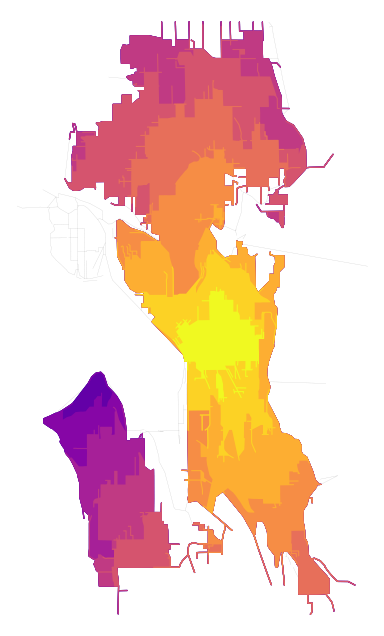

In [29]:
fig, ax = ox.plot_graph(sGraph, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
poly_gdf.plot(ax=ax, color=iso_colors)
plt.savefig('./maps/SeattleNetwork_Planned_nobg.jpeg')
plt.show()

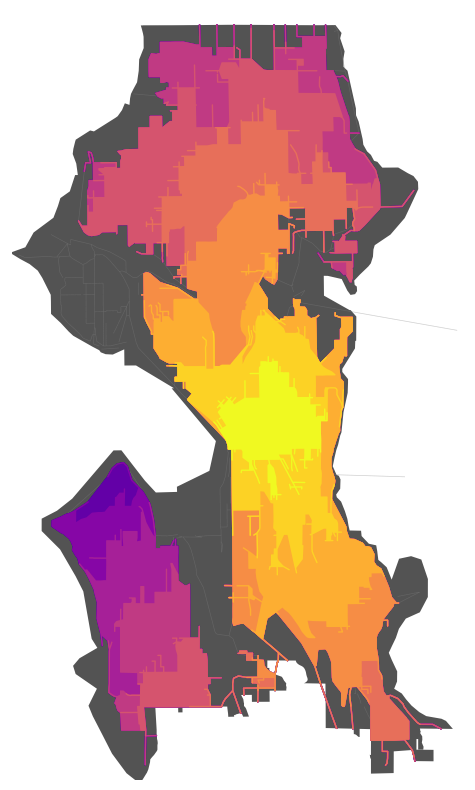

In [28]:
fig, ax = plt.subplots(figsize=(14,10))
#maybe some type of base map to show where the water is and how there is no connection across
seaCity.plot(ax=ax, color='#535353')
ox.plot_graph(sGraph, ax=ax, show=False, close=False, edge_linewidth=0.5, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
poly_gdf.plot(ax=ax, color=iso_colors)
ax.set_axis_off()
plt.savefig('./maps/SeattleNetwork_Planned.jpeg')
plt.show()

<h2>Accessibility Calculations</h2>

In [21]:
sArea = seaCity.area/1000000

In [22]:
min10 = poly_gdf.iloc[-1]
min10 = gpd.GeoDataFrame(geometry=min10)
min10 = min10.clip(seaCity)
area10 = min10.area/1000000
per10 = (area10/sArea[0])*100
print(f'{per10[0]:.1f}% of Seattle will be accessibile by bike within 10 minutes from the city center.')

3.8% of Seattle will be accessibile by bike within 10 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10127/1287010375.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per10[0]:.1f}% of Seattle will be accessibile by bike within 10 minutes from the city center.')


In [23]:
min30 = poly_gdf.iloc[-3]
min30 = gpd.GeoDataFrame(geometry=min30)
min30 = min30.clip(seaCity)
area30 = min30.area/1000000
per30 = (area30/sArea[0])*100
print(f'{per30[0]:.1f}% of Seattle will be accessibile by bike within 30 minutes from the city center.')

20.5% of Seattle will be accessibile by bike within 30 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10127/1431759100.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per30[0]:.1f}% of Seattle will be accessibile by bike within 30 minutes from the city center.')


In [24]:
min60 = poly_gdf.iloc[-6]
min60 = gpd.GeoDataFrame(geometry=min60)
min60 = min60.clip(seaCity)
area60 = min60.area/1000000
per60 = (area60/sArea[0])*100
print(f'{per60[0]:.1f}% of Seattle will be accessibile by bike within 60 minutes from the city center.')

50.8% of Seattle will be accessibile by bike within 60 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10127/2643190295.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per60[0]:.1f}% of Seattle will be accessibile by bike within 60 minutes from the city center.')


In [25]:
min90 = poly_gdf.iloc[3]
min90 = gpd.GeoDataFrame(geometry=min90)
min90 = min90.clip(seaCity)
area90 = min90.area/1000000
per90 = (area90/sArea[0])*100
print(f'{per90[0]:.1f}% of Seattle will be accessibile by bike within 90 minutes from the city center.')

64.5% of Seattle will be accessibile by bike within 90 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10127/2961186332.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per90[0]:.1f}% of Seattle will be accessibile by bike within 90 minutes from the city center.')


In [26]:
min120 = poly_gdf.iloc[0]
min120 = gpd.GeoDataFrame(geometry=min120)
min120 = min120.clip(seaCity)
area120 = min120.area/1000000
per120 = (area120/sArea[0])*100
print(f'{per120[0]:.1f}% of Seattle will be accessibile by bike within 120 minutes from the city center.')

65.3% of Seattle will be accessibile by bike within 120 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10127/433184016.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per120[0]:.1f}% of Seattle will be accessibile by bike within 120 minutes from the city center.')
